# 多场景下的算法构建  

某公司A,B产品在2018年1,2,3月的销量数据，数据格式为xlsx。  

按要求进行预测。

***

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
% matplotlib inline
plt.style.use('ggplot')

1、批量读取数据，并输出以下信息  
（1）数据量  
（2）数据字段columns  
（3）输出每个文件分别有多少缺失值  

In [19]:
def input_data():
    path = input('File Path:')
    print()
    folder = os.walk(path)
    files = list(folder)[0][2]
    for index in files:
        data = pd.read_excel(path + index, index_col=0)
        print('数据长度为 {}'.format(len(data)))
        print('数据字段有 {}'.format(data.columns.tolist()))
        print('数据缺失量 {}'.format(len(data[data.isnull().values==True])))
        print('*'*35)
        
input_data()

File Path:C:\Users\l\Desktop\sales_data\

数据长度为 31
数据字段有 ['productA', 'productB']
数据缺失量 3
***********************************
数据长度为 28
数据字段有 ['productA', 'productB']
数据缺失量 4
***********************************
数据长度为 31
数据字段有 ['productA', 'productB']
数据缺失量 3
***********************************


os.walk返回一个三元组(root,dirs,files)。  
- root 所指的是当前正在遍历的这个文件夹的本身的地址
- dirs 是一个 list ，内容是该文件夹中所有的目录的名字(不包括子目录)
- files 同样是 list , 内容是该文件夹中所有的文件(不包括子目录)

***

2、批量读取数据，用均值填充缺失值数据，并完成以下计算及图表制作  
（1）读取数据并用均值填充缺失值；对“日期”字段进行时间序列处理，转换成日period ，最后输出三个Dataframe文件data1,data2,data3  
（2）分别计算data1，data2，data3中A,B产品的月总销量，并绘制多系列柱状图，存储在对应的图片文件夹路径  
（3）分别计算A产品在每个月中哪一天超过了月度80%的销量，输出日期

File Path:C:\Users\l\Desktop\sales_data\

Image Saved！ Location：C:\Users\l\Desktop\sales_data\img

A产品月度超过80%的销量日期分别为 ['2018-01-26', '2018-02-23', '2018-03-25']



['2018-01-26', '2018-02-23', '2018-03-25']

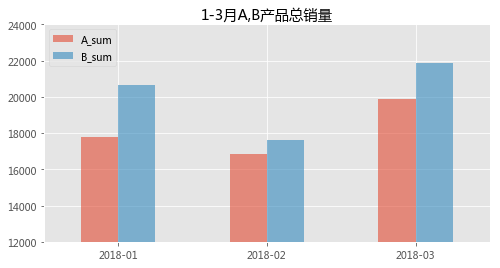

In [20]:
def clean_data():
    path = input('File Path:')
    print()
    folder = os.walk(path)
    files = list(folder)[0][2]
    data_collection = []
    for idx in files:
        data = pd.read_excel(path + idx, index_col=0)
        columns = data.columns.tolist()
        data.to_period()
        data[columns[0]].fillna(data[columns[0]].mean(), inplace=True)
        data[columns[1]].fillna(data[columns[1]].mean(), inplace=True)
        data_collection.append(data)
    return data_collection

def month_sales(*data_collection):
    path = r'C:\Users\l\Desktop\sales_data\img'
    A_sum, B_sum = [], []
    for data in data_collection:
        columns = data.columns  # 提取列名
        A_sum.append(data[columns[0]].sum())
        B_sum.append(data[columns[1]].sum())

    df = pd.DataFrame({'A_sum': A_sum,'B_sum':B_sum}, index=pd.period_range('201801','201803',freq = 'M'))
    df.plot(kind = 'bar', alpha = 0.6, rot = 0, figsize = (8,4), grid=True)
    plt.title('1-3月A,B产品总销量')
    plt.ylim([12000,24000])
    plt.savefig(path + r'\1-3月A,B产品总销量柱状图.png', dpi=400)
    print('Image Saved！ Location：{}\n'.format(path))
    
def month_kpi(*data_collection):
    keydates = []
    for data in data_collection:
        columns = data.columns
        data['A_sale_sum%'] = data[columns[0]].cumsum() / data[columns[0]].sum()
        keydate = data[data['A_sale_sum%']>0.8].index[0]  
        keydates.append(str(keydate).split()[0])
        # 记录销量超过80%的日期
    print('A产品月度超过80%的销量日期分别为 {}\n'.format(keydates))
    return(keydates)

data = clean_data()
data1 , data2, data3 = data[0], data[1], data[2]
month_sales(data1, data2, data3)
month_kpi(data1, data2, data3)

***

3、读取数据并合并，做散点图观察A,B产品销量，并做回归，预测当A销量为1200时，B产品销量值  
（1）读取数据删除缺失值；对“日期”字段进行时间序列处理，转换成日period ，合并三个月数据，输出data；  
（2）针对A产品销量和B产品销量数据做回归分析，制作散点图并存储，并预测当A销量为1200时，B产品销量值  

File Path:C:\Users\l\Desktop\sales_data\

预测当A销量为1200时，B产品销量值为1303.84

AB产品销量关系为：


array([1303.84193309])

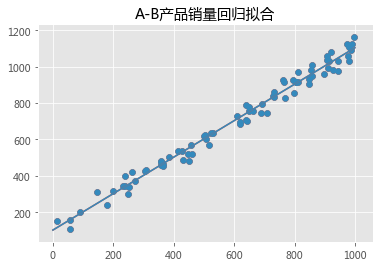

In [21]:
def train_data():
    path = input('File Path:')
    print()
    folder = os.walk(path)
    files = list(folder)[0][2]
    data_collection = []
    for idx in files:
        data = pd.read_excel(path + idx, index_col = 0)
        columns = data.columns.tolist()
        data.to_period()
        data.dropna(inplace=True)
        data_collection.append(data)
    data = pd.concat([data_collection[0],data_collection[1],data_collection[2]])
    return(data)

def test_data(test):
    path = r'C:\Users\l\Desktop\sales_data\img'
    model = LinearRegression()
    model.fit(test['productA'][:,np.newaxis], test['productB'])  
    # 构建回归模型
    xtest = np.linspace(0,1000,1000)
    ytest = model.predict(xtest[:,np.newaxis])
    plt.scatter(test['productA'], test['productB'])
    plt.plot(xtest, ytest)
    plt.grid()
    plt.title('A-B产品销量回归拟合')
    plt.savefig(path + r'\A-B产品销量回归拟合.png', dpi=400)  
    return(model.predict(1200))

data = train_data()
print('预测当A销量为1200时，B产品销量值为{:.2f}'.format(test_data(data)[0]))
print()
print('AB产品销量关系为：')
test_data(data)